Моделируемое уравнение: $\dot{\phi}_j = \displaystyle\frac{\mu}{2} \Big[ \omega_j + \displaystyle\frac{d}{R_j}\sum_{k=1}^N{R_k(\sin(\phi_k-\phi_j-\gamma))} \Big], \quad j\neq k$


In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from numba import jit
from pprint import pprint

In [2]:
# Параметры системы
N = 128
mu = 0.1
d = 0.3
omega = np.ones(N) 
R = np.ones(N)
gamma = 3*np.pi/4

## Система

In [3]:
@jit(nopython=True)
def system(phi, t, N, mu, omega, gamma, d, R):
    result = np.zeros_like(phi)

    for j in range(N):
        sum_term = 0.0
        for k in range(N):
            if j != k:
                sum_term += R[k] * np.sin(phi[k] - phi[j] - gamma)

        result[j] = mu / 2 * (omega[j] + d / R[j] * sum_term)

    return result

phi0 =  np.arange(0, 2*np.pi, 2*np.pi/N)

t_span = np.linspace(0, 1000, 1000)

solution = odeint(system, phi0, t_span, args=(N, mu, omega, gamma, d, R))

solution = np.fmod(solution, 2*np.pi)               # приведение к [0, 2пи]
solution[solution == 2*np.pi] -= 2*np.pi            # 0 и 2пи на окружности одна точка
solution[solution < 0] += 2*np.pi                   # отрицательные привели к [0, 2пи]

pprint(solution)

array([[0.        , 0.04908739, 0.09817477, ..., 6.13592315, 6.18501054,
        6.23409792],
       [0.06066727, 0.10975465, 0.15884204, ..., 6.19659042, 6.24567781,
        0.01157988],
       [0.12133454, 0.17042192, 0.21950931, ..., 6.25725769, 0.02315977,
        0.07224715],
       ...,
       [3.93659942, 3.9856868 , 4.03477419, ..., 3.78933726, 3.83842464,
        3.88751203],
       [3.99726668, 4.04635407, 4.09544145, ..., 3.85000453, 3.89909191,
        3.9481793 ],
       [4.05793395, 4.10702134, 4.15610872, ..., 3.9106718 , 3.95975918,
        4.00884657]])


## Параметры порядка:

$R_1=\displaystyle \frac{1}{N}\Big|\sum^N_{j=2}e^{2i\pi\phi_j}\Big|$

$R_2=\displaystyle \frac{1}{N}\Big|\sum^N_{j=2}e^{4i\pi\phi_j}\Big|$

Final values of R1 and R2:
R1: 0.033502299979086436
R2: 0.02333343839582851


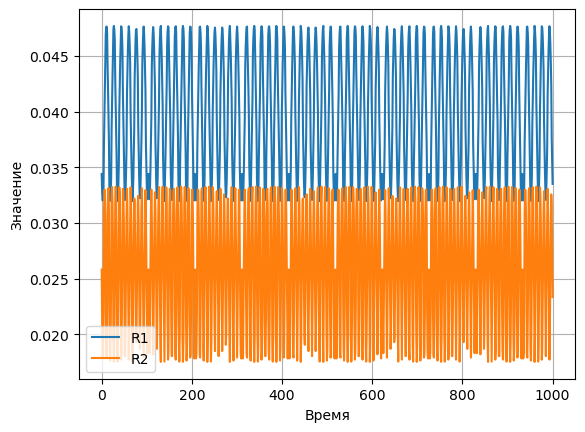

In [4]:
R1 = np.abs(np.mean(np.exp(2j * np.pi * solution[:, 1:]), axis=1) )
R2 = np.abs(np.mean(np.exp(4j * np.pi * solution[:, 1:]), axis=1) )

print("Final values of R1 and R2:")
print(f"R1: {R1[-1]}")
print(f"R2: {R2[-1]}")

# Построение графиков параметров порядка
plt.plot(t_span, R1, label='R1')
plt.plot(t_span, R2, label='R2')
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()


## Пространственно-временная диаграмма

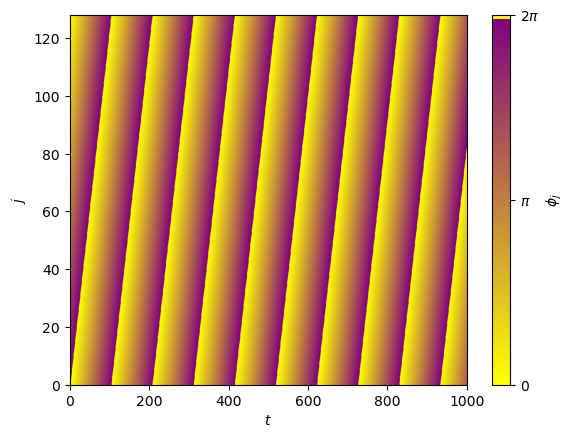

In [5]:
# Создание цветовой карты
colors = ['#FFFF00', '#800080']
n_bins = 100  # Количество оттенков

# 0 и 2*pi одним цветом
color_map_values = np.linspace([1, 1, 0], [128/255, 0, 128/255], n_bins)
color_map_values[0, :] = color_map_values[-1, :] = [1, 1, 0]

cmap_name = "custom_gradient"
custom_cmap = ListedColormap(color_map_values)

# Построение пространственно-временной диаграммы с градиентом цветовой карты
fig, ax = plt.subplots()
im = ax.imshow(solution.T, aspect='auto', cmap=custom_cmap, extent=[t_span[0], t_span[-1], 0, N], vmin=0, vmax=2*np.pi)
cb = plt.colorbar(im, ax=ax, label=fr'$\phi_j$', ticks=[0,np.pi,2*np.pi])
cb.set_ticklabels(['$0$', '$\pi$', '$2\pi$'])

plt.xlabel(fr'$t$')
plt.ylabel(fr'$j$')
plt.show()

## Распределение осцилляторов

final time

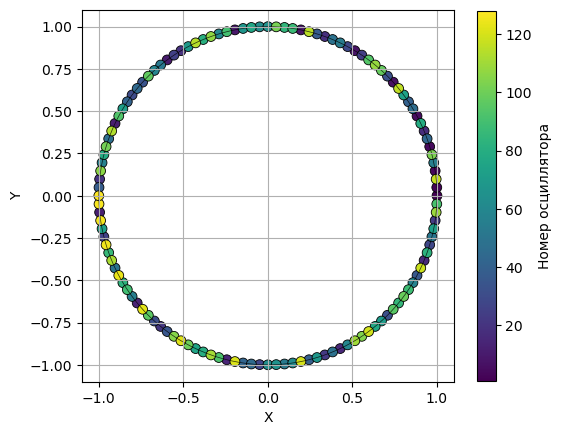

In [8]:
phi_diff = solution[-1, 1:] - solution[-1, 0]

theta = np.cumsum(np.concatenate(([0], phi_diff))) % (2 * np.pi)

x = np.cos(theta)
y = np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=range(1, N+1), cmap='viridis', s=50, edgecolor='black', linewidth=0.6)
ax.set_aspect('equal', 'box')

circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=0.5, alpha=0.8)
ax.add_patch(circle)
ax.grid()

cbar = plt.colorbar(sc, shrink=0.8)
cbar.set_label('Номер осциллятора')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()